In [1]:
import pandas as pd
import os
import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter    


In [36]:
def find_ACA(data, max_difference = 1.0, min_size = 5, max_size = 50):
    data_advance = data.loc[data['Status'] == 'Advancing']
    ACA_plateau = pd.DataFrame(columns=data_advance.columns)
    chunk_size = max_size
    while chunk_size >= min_size:
        for index in range(len(data_advance) - chunk_size):
            chunk = data_advance.loc[index : index + chunk_size]
            d = chunk["Data_Angle"].max() - chunk["Data_Angle"].min()
            if d < max_difference:
                ACA_plateau = ACA_plateau.append(chunk)
        if ACA_plateau.empty == False:
            break
        chunk_size = chunk_size - 1
    return ACA_plateau

def find_RCA(data, max_dangle = 1.0, min_dbase = 0.1, min_size = 3, max_size = 50):
    data_receding = data.loc[data['Status'] == 'Receding']
    RCA_plateau = pd.DataFrame(columns=data_receding.columns)
    chunk_size = max_size
    while chunk_size >= min_size:
        for index in range(len(data_receding) - chunk_size):
            chunk = data_receding.loc[index : index + chunk_size]
            da = chunk["Smoothed_Angle"].max() - chunk["Smoothed_Angle"].min()
            db = chunk["Smoothed_Base"].max() - chunk["Smoothed_Base"].min()
            if (da < max_dangle) & (db > min_dbase):
                RCA_plateau = RCA_plateau.append(chunk)
        if RCA_plateau.empty == False:
            break
        chunk_size = chunk_size - 1
    return RCA_plateau

In [37]:
path = '/Users/yxl044/OneDrive - University of Birmingham/DOCUMENTS/P&G visit/contact angle/Siwafer/try'
files = glob.glob(os.path.join(path, '*.txt'))


In [38]:
data_name = []
test_number = 33

for i in range(len(files)):
    x = str(files[i]).split('/')
    current_name = x[-1].split('.')[0]
    data_name.append(current_name)

data_name

['Silwet L-7001_Siwafer_1',
 'ABIL EM 97S_Siwafer_3',
 'Silwet L-7001_Siwafer_3',
 'ABIL EM 97S_Siwafer_1',
 'Silwet L-7001_Siwafer_2',
 'ABIL EM 97S_Siwafer_4',
 'dehydrated SFO_Siwafer_3',
 'Silwet L-7200_Siwafer_1',
 'dehydrated SFO_Siwafer_2',
 'Silwet L-7200_Siwafer_3',
 'Silwet L-7200_Siwafer_2',
 'dehydrated SFO_Siwafer_1',
 'SFO_Siwafer_1',
 'Silsoft 870_Siwafer_2',
 'saturated SFO_Siwafer_1',
 'Silsoft 870_Siwafer_3',
 'Silsoft 870_Siwafer_1',
 'SFO_Siwafer_2',
 'saturated SFO_Siwafer_2',
 'saturated SFO_Siwafer_3',
 'SFO_Siwafer_3',
 'Silsoft 875_Siwafer_2',
 'KF-6013_Siwafer_1',
 'Silsoft 875_Siwafer_3',
 'KF-6013_Siwafer_3',
 'KF-6013_Siwafer_2',
 '55cSt Silicones_Siwafer_1',
 '55cSt Silicones_Siwafer_3',
 '55cSt Silicones_Siwafer_2',
 'DIwater_Siwafer_1',
 'DIwater_Siwafer_3',
 'DIwater_Siwafer_2',
 'DIwater_Siwafer_4']

In [39]:
data_list = dict()
CA_list = dict()
sum_table = pd.DataFrame(columns=['ACA [˚]', 'ACA std', 'RCA [˚]', 'RCA std', 'Replica'])
test_number = 33
data_ACA = np.zeros(test_number)
ACA_std = np.zeros(test_number)
data_RCA = np.zeros(test_number)
RCA_std = np.zeros(test_number)
liquid = [" "] * test_number
replica = np.zeros(test_number)
substrate = [" "] * test_number

for i in range(len(files)):
    # import data
    current_df = pd.read_fwf(files[i],header =None)
    # mix first two rows for headers
    current_df.columns = (current_df.iloc[0] + '_' + current_df.iloc[1])
    current_df = current_df.iloc[2:].reset_index(drop=True)
    
    # extract wanted columns time, angle and base
    current_data = current_df[['Graph_Secs','Data_Angle', 'Data_Base']]
    current_df = current_df.dropna(axis=0)
    current_data = current_data.astype(float)

    # get smoothed data, remove noise
    num1 = current_data.shape[0]//3
    if num1%2 == 0:
        current_data['Smoothed_Angle'] = savgol_filter(current_data['Data_Angle'], window_length=(num1+1), polyorder=3)
    else:
        current_data['Smoothed_Angle'] = savgol_filter(current_data['Data_Angle'], window_length=num1, polyorder=3)
    
    num2 = current_data.shape[0]//2
    if num2%2 == 0:
        current_data['Smoothed_Base'] = savgol_filter(current_data['Data_Base'], window_length=(num2+1), polyorder=3)
    else:
        current_data['Smoothed_Base'] = savgol_filter(current_data['Data_Base'], window_length=num2, polyorder=3)

    # change nan in gradient to 0
    base_gradient = np.nan_to_num(np.gradient(current_data.Smoothed_Base))
    current_data['Base_gradient'] = base_gradient.tolist()
    base_gradient_max = np.amax(base_gradient)

    # current_data = current_data[(current_data['Base_gradient'] < 0)|(current_data['Base_gradient'] >= 0.25*base_gradient_max)]
    current_data["Status"] = np.where(current_data.Base_gradient >= 0.25*base_gradient_max, 'Advancing', 'Receding')
    ind = current_data.loc[current_data["Status"] == 'Advancing'].index[0]
    current_data.drop(current_data.index[:ind], inplace=True)
    
    current_CA = current_data.drop(current_data[(current_data['Base_gradient'] >= 0) & (current_data['Status'] == 'Receding')].index, inplace=False)
    
    current_ACA = find_ACA(current_CA)
    current_RCA = find_RCA(current_CA)
    current_result = current_ACA.append(current_RCA)

    current_result['Substrate'] = str(data_name[i]).split('_')[1]
    current_result['liquid'] = str(data_name[i]).split('_')[0]
    current_result['Replica'] = int(str(data_name[i]).split('_')[2])

    data_ACA[i] = np.mean(current_ACA['Data_Angle'])
    ACA_std[i] = np.std(current_ACA['Data_Angle'])

    if current_RCA.empty == True:
        data_RCA[i] = 0
        RCA_std[i] = 0
    else:
        data_RCA[i] = np.mean(current_RCA['Data_Angle'])
        RCA_std[i] = np.std(current_RCA['Data_Angle'])

    liquid[i] = str(data_name[i]).split('_')[0]
    substrate[i] = str(data_name[i]).split('_')[1]
    replica[i] = int(str(data_name[i]).split('_')[2])


    data_list[data_name[i]] = current_data
    CA_list[data_name[i]] = current_result


sum_table['ACA [˚]'] = data_ACA.tolist()
sum_table['ACA std'] = ACA_std.tolist()
sum_table['RCA [˚]'] = data_RCA.tolist()
sum_table['RCA std'] = RCA_std.tolist()
sum_table['Replica'] = replica.tolist()
substrate_sum = pd.Series(substrate)
sum_table.insert(loc=0, column='Substrate', value=substrate_sum)
liquid_sum = pd.Series(liquid)
sum_table.insert(loc=0, column='Liquid', value=liquid_sum)

/var/folders/t8/s3wbxd3j28sbrflrxg8_rz7x934gjg/T/ipykernel_4504/3835871410.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ACA_plateau = ACA_plateau.append(chunk)
/var/folders/t8/s3wbxd3j28sbrflrxg8_rz7x934gjg/T/ipykernel_4504/657561898.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  current_result = current_ACA.append(current_RCA)
/var/folders/t8/s3wbxd3j28sbrflrxg8_rz7x934gjg/T/ipykernel_4504/3835871410.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ACA_plateau = ACA_plateau.append(chunk)
/var/folders/t8/s3wbxd3j28sbrflrxg8_rz7x934gjg/T/ipykernel_4504/657561898.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  curre

In [40]:
CA_list['55cSt Silicones_Siwafer_1']

,Graph_Secs,Data_Angle,Data_Base,Smoothed_Angle,Smoothed_Base,Base_gradient,Status,Substrate,liquid,Replica
162,14.58,15.37,7.3811,16.015546,7.364022,0.017705,Advancing,Siwafer,55cSt Silicones,1
163,14.67,15.07,7.3952,15.962239,7.381618,0.017491,Advancing,Siwafer,55cSt Silicones,1
164,14.76,15.06,7.3952,15.913299,7.399004,0.017226,Advancing,Siwafer,55cSt Silicones,1
165,14.85,15.38,7.4093,15.887512,7.416070,0.017028,Advancing,Siwafer,55cSt Silicones,1
166,14.94,15.06,7.4375,15.818576,7.433061,0.016883,Advancing,Siwafer,55cSt Silicones,1
167,15.03,15.42,7.4515,15.763284,7.449836,0.016602,Advancing,Siwafer,55cSt Silicones,1
168,15.12,14.70,7.4797,15.696295,7.466265,0.016124,Advancing,Siwafer,55cSt Silicones,1
169,15.21,14.56,7.4938,15.621610,7.482084,0.015574,Advancing,Siwafer,55cSt Silicones,1
170,15.30,14.67,7.4938,15.546593,7.497413,0.015274,Advancing,Siwafer,55cSt Silicones,1
171,15.39,15.24,7.4938,15.459173,7.512632,0.015235,Advancing,Siwafer,55cSt Silicones,1


In [41]:
data_list['55cSt Silicones_Siwafer_1']

,Graph_Secs,Data_Angle,Data_Base,Smoothed_Angle,Smoothed_Base,Base_gradient,Status
4,0.36,18.97,2.8877,16.268668,2.934371,0.009730,Advancing
5,0.45,18.69,2.8877,16.421319,2.944443,0.010409,Advancing
6,0.54,19.83,2.8736,16.570930,2.955188,0.011078,Advancing
7,0.63,20.09,2.8736,16.717516,2.966600,0.011740,Advancing
8,0.72,19.41,2.8736,16.861088,2.978668,0.012392,Advancing
...,...,...,...,...,...,...,...
333,30.33,0.78,8.2686,1.377123,8.290056,-0.001522,Receding
334,30.42,0.91,8.2686,1.476525,8.288507,-0.001575,Receding
335,30.51,0.36,8.2686,1.584003,8.286906,-0.001628,Receding
336,30.60,0.77,8.2404,1.699678,8.285252,-0.001680,Receding


In [53]:
sum_table = pd.read_csv('/Users/yxl044/OneDrive - University of Birmingham/DOCUMENTS/P&G visit/contact angle/Siwafer/Siwafer_95SFO.csv')
sum_table

,Unnamed: 0,Liquid,Substrate,ACA [˚],ACA std,RCA [˚],RCA std,Replica
0,0,Silwet L-7001,Siwafer,31.565714,0.467649,0.0,0.0,1.0
1,1,ABIL EM 97S,Siwafer,40.381724,0.235958,0.0,0.0,3.0
2,2,Silwet L-7001,Siwafer,28.685897,0.254707,0.0,0.0,3.0
3,3,ABIL EM 97S,Siwafer,42.568603,0.189558,0.0,0.0,1.0
4,4,Silwet L-7001,Siwafer,31.675638,0.432677,0.0,0.0,2.0
5,5,ABIL EM 97S,Siwafer,39.990669,0.205672,0.0,0.0,4.0
6,6,dehydrated SFO,Siwafer,31.782667,0.289746,0.0,0.0,3.0
7,7,Silwet L-7200,Siwafer,30.965600,0.270852,0.0,0.0,1.0
8,8,dehydrated SFO,Siwafer,33.607097,0.255888,0.0,0.0,2.0
9,9,Silwet L-7200,Siwafer,30.351395,0.273433,0.0,0.0,3.0


In [60]:
sum_table.loc[sum_table['Liquid'] == 'Silwet L-7200', 'ACA [˚]'].mean()

30.755968146582102

In [49]:
sum_table.describe()

,ACA [˚],ACA std,RCA [˚],RCA std,Replica
count,33.000000,33.000000,33.0,33.0,33.000000
mean,32.747282,0.260213,0.0,0.0,2.151515
std,7.504745,0.060213,0.0,0.0,0.939455
min,14.650000,0.175282,0.0,0.0,1.000000
25%,30.017442,0.223331,0.0,0.0,1.000000
50%,31.675638,0.247451,0.0,0.0,2.000000
75%,39.799500,0.282357,0.0,0.0,3.000000
max,45.540952,0.456786,0.0,0.0,4.000000


In [ ]:
sum_table.to_csv('/Users/yxl044/OneDrive - University of Birmingham/DOCUMENTS/P&G visit/contact angle/Siwafer/Siwafer_95SFO.csv')

In [67]:
SFO_com = sum_table.loc[sum_table['Liquid'].isin(['SFO', 'dehydrated SFO','saturated SFO', 'DIwater'])]

In [73]:
sns.barplot(data = sum_table, y = SFO_com['ACA [˚]'], x = SFO_com['Liquid'], ci = "std")
plt.xticks(rotation=45)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:

for test in data_list.keys():
    ACA_range = data_list[str(test)].loc[data_list[str(test)].Status == 'Advancing']
    ACA_angle = np.mean(ACA_range['Data_Angle'])
    RCA_range = data_list[str(test)].loc[data_list[str(test)].Status == 'Advancing']
    print("the ACA for {} is {}".format(test, ACA_angle))

In [70]:
# # sns.lineplot(data = CA_list['Silsoft 870_Siwafer_1'][['Smoothed_Base', 'Smoothed_Angle']])

# for test in CA_list.keys():
#     sns.lineplot(y =CA_list[str(test)].Data_Angle, x = CA_list[str(test)].Graph_Secs, color="g", label = "Angle", hue = CA_list[str(test)].Status).set(title= str(test))
#     ax2 = plt.twinx()
#     sns.lineplot(y = CA_list[str(test)].Base_gradient,x = CA_list[str(test)].Graph_Secs, color="b", ax=ax2, label = "Base Gradient")
#     ax2.legend(loc ="upper right", bbox_to_anchor=(1, 0.9))
#     plt.show()


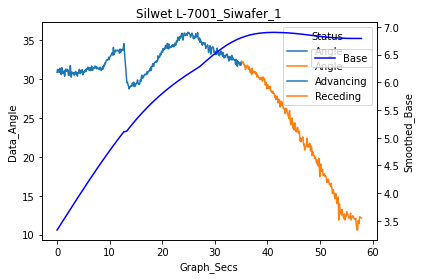

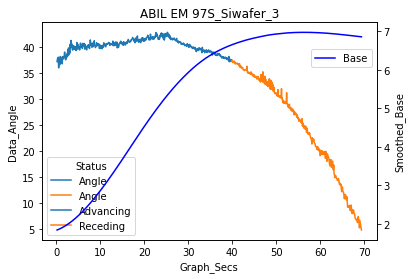

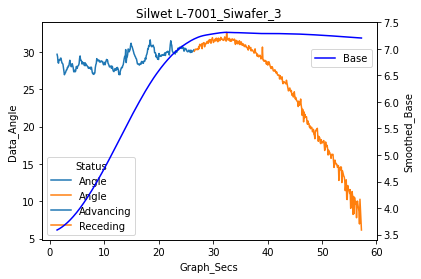

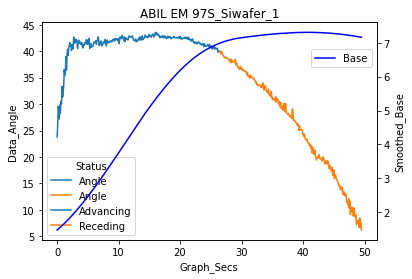

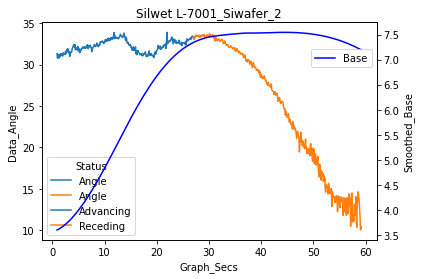

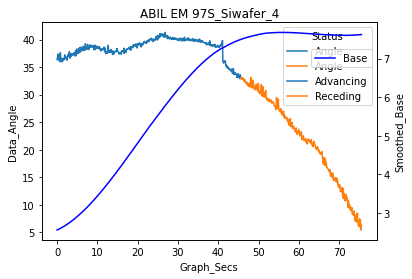

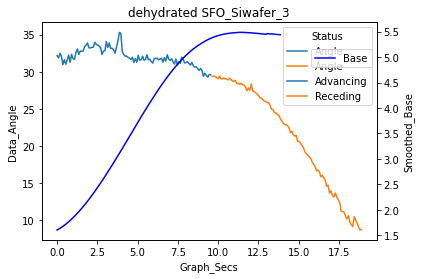

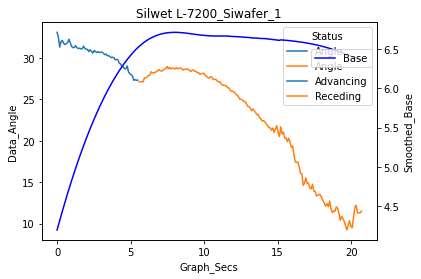

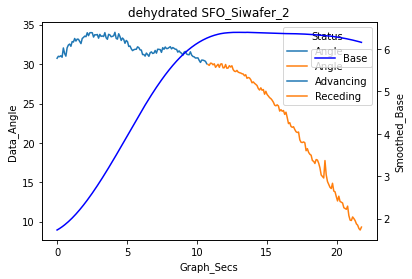

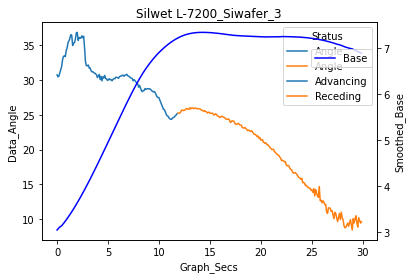

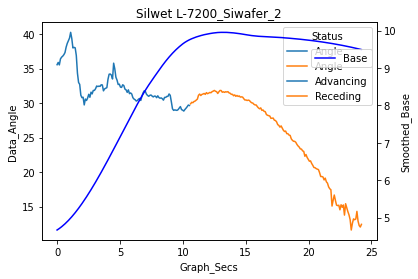

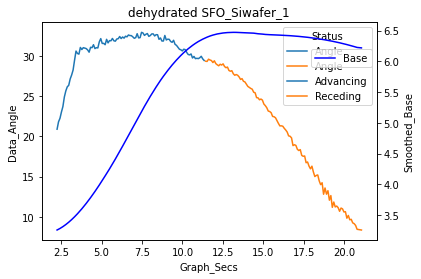

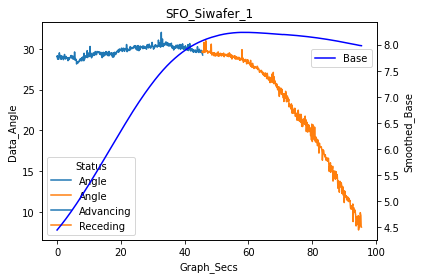

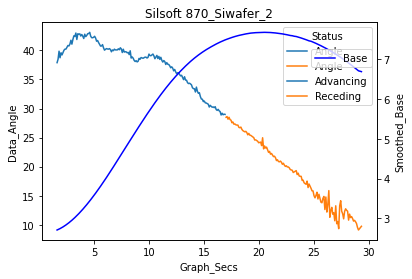

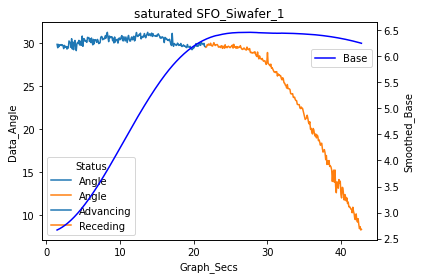

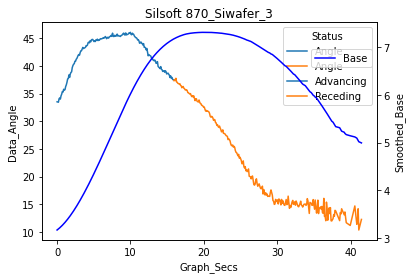

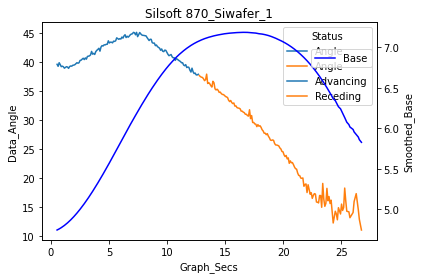

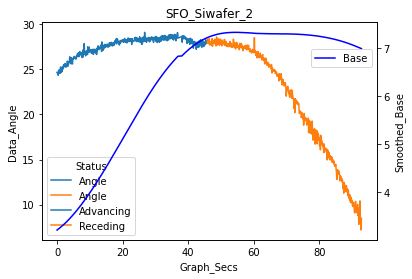

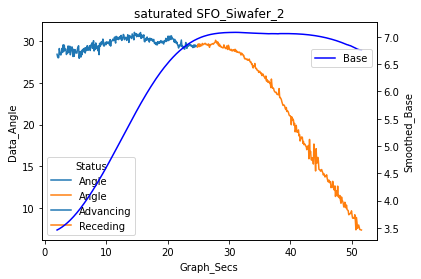

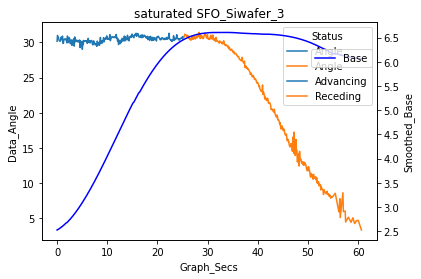

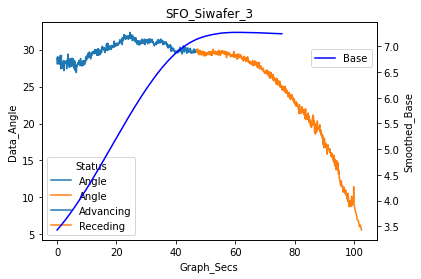

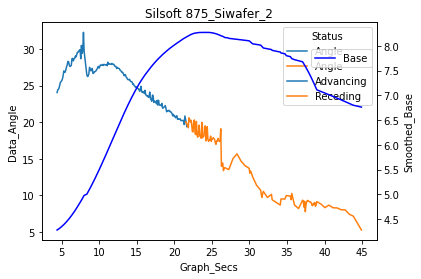

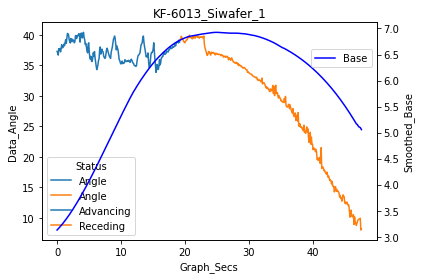

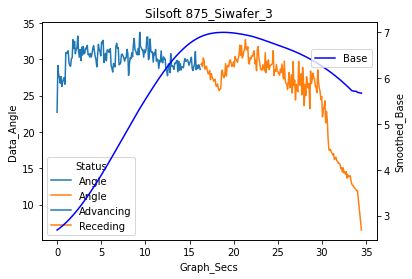

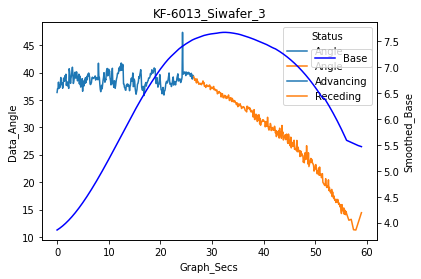

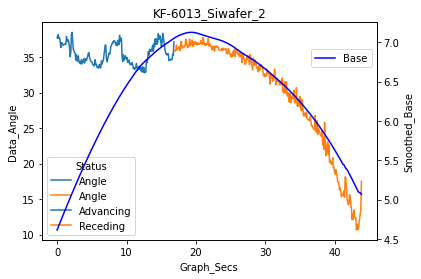

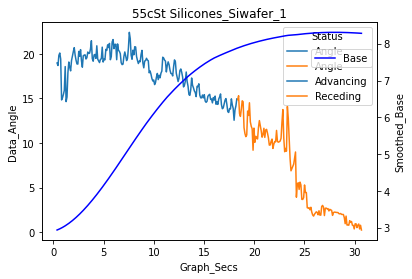

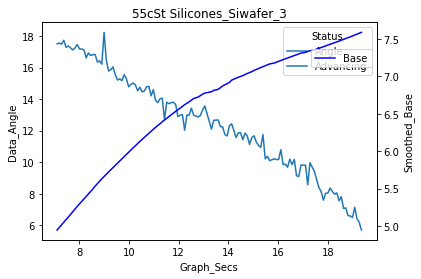

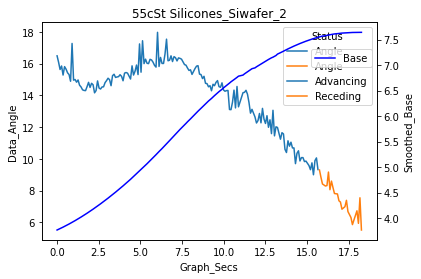

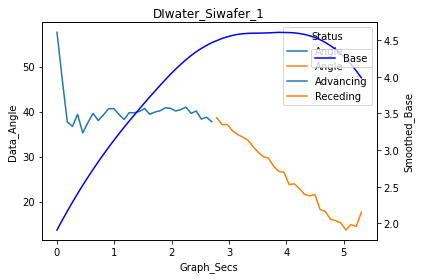

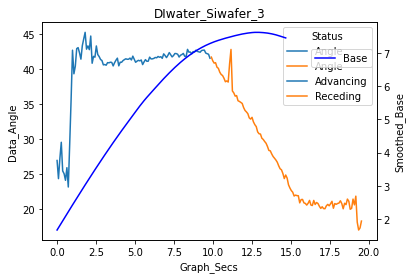

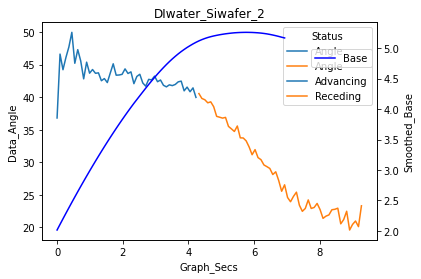

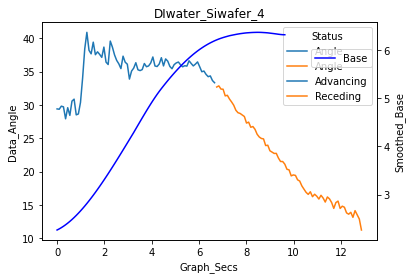

In [71]:
# sns.lineplot(data = data_list['Silsoft 870_Siwafer_1'][['Smoothed_Base', 'Smoothed_Angle']])

for test in data_list.keys():
    sns.lineplot(y =data_list[str(test)].Data_Angle, x = data_list[str(test)].Graph_Secs, color="g", label = "Angle", hue = data_list[str(test)].Status).set(title= str(test))
    ax2 = plt.twinx()
    sns.lineplot(y = data_list[str(test)].Smoothed_Base ,x = data_list[str(test)].Graph_Secs, color="b", ax=ax2, label = "Base")
    ax2.legend(loc ="upper right", bbox_to_anchor=(1, 0.9))
    plt.show()


In [ ]:
for i in range(len(data)):
    data[]

<AxesSubplot: xlabel='Data_Base', ylabel='Data_Angle'>

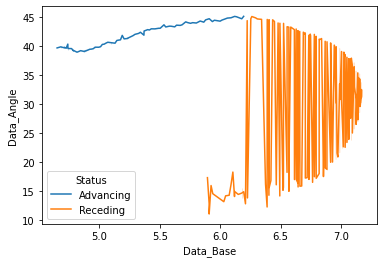

In [137]:
sns.lineplot(x = data_list['Silsoft 870_Siwafer_1']['Data_Base'], y = data_list['Silsoft 870_Siwafer_1']['Data_Angle'], hue = data_list['Silsoft 870_Siwafer_1']['Status'])

<AxesSubplot: xlabel='Graph_Secs', ylabel='Smoothed_Base'>

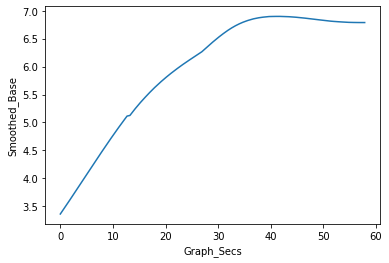

In [6]:
# Trial with single file
df = pd.read_fwf('/Users/yxl044/OneDrive - University of Birmingham/DOCUMENTS/P&G visit/contact angle/Siwafer/try/Silwet L-7001_Siwafer_1.txt',header =None)


df.columns = (df.iloc[0] + '_' + df.iloc[1])
df = df.iloc[2:].reset_index(drop=True)

data = df[['Graph_Secs','Data_Angle', 'Data_Base']]
data = data.dropna(axis=0)
data = data.astype(float)

# num = data.shape[0]//6
# if num%2 == 0:
#     data['Smoothed_Angle'] = savgol_filter(data['Data_Angle'], window_length=(num+1), polyorder=3)
#     data['Smoothed_Base'] = savgol_filter(data['Data_Base'], window_length=(num+1), polyorder=3)
# else:
data['Smoothed_Angle'] = savgol_filter(data['Data_Angle'], window_length=301, polyorder=3)
data['Smoothed_Base'] = savgol_filter(data['Data_Base'], window_length=301, polyorder=3)

sns.lineplot(x = data['Graph_Secs'], y = data['Smoothed_Base'])


In [551]:
max_base = data.Smoothed_Base.idxmax()
data["Status"] = np.where(data.index <= max_base, 'Advancing', 'Receding')
base_gradient = np.nan_to_num(np.gradient(data.Smoothed_Base))
data['Base_gradient'] = base_gradient.tolist()
base_gradient_max = np.amax(base_gradient)

min_angle = data.Smoothed_Angle.idxmin()
data = data[:min_angle]

In [552]:
data

,Graph_Secs,Data_Angle,Data_Base,Smoothed_Angle,Smoothed_Base,Status,Base_gradient
0,0.000,30.880,3.539,30.424,3.624,Advancing,-0.003
1,0.090,31.240,3.539,30.448,3.621,Advancing,-0.003
2,0.180,30.940,3.539,30.473,3.619,Advancing,-0.003
3,0.270,31.030,3.540,30.497,3.616,Advancing,-0.002
4,0.360,31.270,3.539,30.521,3.614,Advancing,-0.002
...,...,...,...,...,...,...,...
612,56.970,10.650,6.779,11.297,6.778,Receding,-0.001
613,57.150,10.600,6.878,11.179,6.777,Receding,-0.001
614,57.240,11.800,6.822,11.061,6.776,Receding,-0.001
615,57.420,11.440,6.736,10.943,6.775,Receding,-0.001


In [557]:
a = find_ACA(data)
b = find_RCA(data)
a.shape



/var/folders/t8/s3wbxd3j28sbrflrxg8_rz7x934gjg/T/ipykernel_22117/256808235.py:10: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



(45, 7)

In [558]:
b

,Graph_Secs,Data_Angle,Data_Base,Smoothed_Angle,Smoothed_Base,Status,Base_gradient


In [508]:
data.loc[data['Status'] == 'Receding'].index[0]

454

<AxesSubplot: xlabel='Graph_Secs', ylabel='Smoothed_Base'>

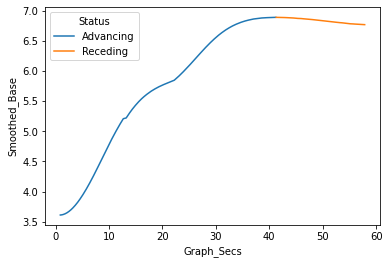

In [384]:
sns.lineplot(x = data['Graph_Secs'], y = data['Smoothed_Base'],hue = data['Status'])

<AxesSubplot: xlabel='Graph_Secs'>

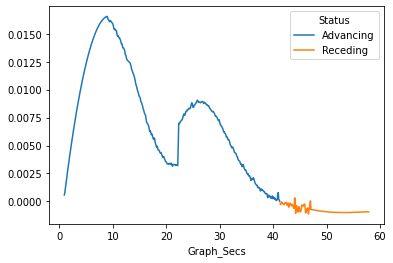

In [386]:
sns.lineplot(x = data['Graph_Secs'], y = np.gradient(data['Smoothed_Base']),hue = data['Status'])


In [346]:
# smooth data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter    
import plotly.graph_objects as go




fig = go.Figure()

fig.add_trace(go.Scatter(
    x = data['Graph_Secs'],
    y=data['Data_Angle'],
    mode='markers',
    marker=dict(
        size=6,
        color='#5E88FC',
        symbol='circle-open'
    ),
    name='oringin'
))

fig.add_trace(go.Scatter(
    x = data['Graph_Secs'],
    y=savgol_filter(data['Data_Angle'], window_length=99, polyorder=3),  # setting degree to 10
    mode='markers',
    marker=dict(
        size=6,
        color='#C190F0',
        symbol='triangle-up'
    ),
    name='smoothed'
))

fig.show()



In [329]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = data['Graph_Secs'],
    y=data['Data_Base'],
    mode='markers',
    marker=dict(
        size=6,
        color='#5E88FC',
        symbol='circle-open'
    ),
    name='oringin'
))

fig.add_trace(go.Scatter(
    x = data['Graph_Secs'],
    y=savgol_filter(data['Data_Base'], window_length=99, polyorder=3),  # setting degree to 10
    mode='markers',
    marker=dict(
        size=6,
        color='#C190F0',
        symbol='triangle-up'
    ),
    name='smoothed_base'
))

fig.add_trace(go.Scatter(
    x = data['Graph_Secs'],
    y=savgol_filter(data['Data_Angle'], window_length=99, polyorder=3),  # setting degree to 10
    mode='markers',
    marker=dict(
        size=6,
        color='black',
        symbol='triangle-up'
    ),
    name='smoothed_angle'
))

fig.show()

In [302]:
# # Method 2 for data smoothing, but give total flat lines so can hide details like small contact angle drop




# import plotly.graph_objects as go

# import numpy as np
# import pandas as pd


# def smoothTriangle(data, degree):
#     triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
#     smoothed=[]

#     for i in range(degree, len(data) - degree * 2):
#         point=data[i:i + len(triangle)] * triangle
#         smoothed.append(np.sum(point)/np.sum(triangle))
#     # Handle boundaries
#     smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
#     while len(smoothed) < len(data):
#         smoothed.append(smoothed[-1])
#     return smoothed

# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x = data['Graph_Secs'],
#     y=data['Data_Angle'],
#     mode='markers',
#     marker=dict(
#         size=6,
#         color='#5E88FC',
#         symbol='circle-open'
#     ),
#     name='oringin'
# ))

# fig.add_trace(go.Scatter(
#     x = data['Graph_Secs'],
#     y=smoothTriangle(data['Data_Angle'], 10),  # setting degree to 10
#     mode='markers',
#     marker=dict(
#         size=6,
#         color='#C190F0',
#         symbol='triangle-up'
#     ),
#     name='smoothed'
# ))

# fig.show()


In [357]:
f = np.array([1, 2, 4, 7, 11, 16], dtype=float)
f.size

6

In [296]:
def find_plateaus(F, min_length=200, tolerance = 0.75, smoothing=25):
    '''
    Finds plateaus of signal using second derivative of F.

    Parameters
    ----------
    F : Signal.
    min_length: Minimum length of plateau.
    tolerance: Number between 0 and 1 indicating how tolerant
        the requirement of constant slope of the plateau is.
    smoothing: Size of uniform filter 1D applied to F and its derivatives.
    
    Returns
    -------
    plateaus: array of plateau left and right edges pairs
    dF: (smoothed) derivative of F
    d2F: (smoothed) Second Derivative of F
    '''
    import numpy as np
    from scipy.ndimage.filters import uniform_filter1d
    
    # calculate smooth gradients
    smoothF = uniform_filter1d(F, size = smoothing)
    dF = uniform_filter1d(np.gradient(smoothF),size = smoothing)
    d2F = uniform_filter1d(np.gradient(dF),size = smoothing)
    
    def zero_runs(x):
        '''
        Helper function for finding sequences of 0s in a signal
        https://stackoverflow.com/questions/24885092/finding-the-consecutive-zeros-in-a-numpy-array/24892274#24892274
        '''
        iszero = np.concatenate(([0], np.equal(x, 0).view(np.int8), [0]))
        absdiff = np.abs(np.diff(iszero))
        ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
        return ranges
    
    # Find ranges where second derivative is zero
    # Values under eps are assumed to be zero.
    eps = np.quantile(abs(d2F),tolerance) 
    smalld2F = (abs(d2F) <= eps)
    
    # Find repititions in the mask "smalld2F" (i.e. ranges where d2F is constantly zero)
    p = zero_runs(np.diff(smalld2F))
    
    # np.diff(p) gives the length of each range found.
    # only accept plateaus of min_length
    plateaus = p[(np.diff(p) > min_length).flatten()]
    
    return (plateaus)

In [299]:
find_plateaus(data['Data_Base'], min_length=100, tolerance = 0.75, smoothing=25)

array([[348, 607]])

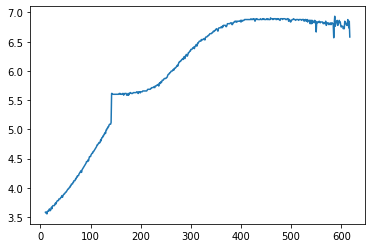

In [300]:
plt.plot(data['Data_Base'])

In [278]:
diff = np.diff(data['Data_Base'])

In [280]:
diff.max()

0.49739999999999984

In [273]:
# df = df.drop(df.columns[4], axis = 1)
# df = df.rename(columns = {df.columns[2]: 'frame'})
# df = df.dropna(axis=0)
# df

In [267]:
os.chdir('/Users/yxl044/OneDrive - University of Birmingham/DOCUMENTS/P&G visit/IFM/replace/data_files') # select your folder where the files are
files = glob.glob("*.csv") #this function takes all csv files in the directory

In [15]:
data = pd.DataFrame(columns=['Stroke', 'Friction force (gf)', 'Bleaching level', 'Treatment', 'Dry/Wet', 'Speed (mm/s)', 'Replica', 'Friction force (N)', 'Dynamic COF'])
for file in files:
    current_df = pd.DataFrame(pd.read_csv(file, skiprows=6, header=None))
    current_df = current_df.iloc[:5,[0,1]] #delete unwanted columns
    
    current_df = current_df.rename(columns ={0: 'Stroke', 1: 'Friction force (gf)'})
    current_df['Friction force (N)'] = current_df['Friction force (gf)']*0.00980665 #convert gf to N
    current_df['Dynamic COF'] = current_df['Friction force (N)']/ 4.0180630139 #grey foam set-up is 409.7284g in total, which is 4.0180630139N

    if file.split('_')[1] == 'V':
            current_df['Bleaching level'] = 'Virgin'
    elif file.split('_')[1] == 'LL':
            current_df['Bleaching level'] = 'Low lift'
    elif file.split('_')[1] == 'P':
            current_df['Bleaching level'] = 'Platinum'
    current_df['Treatment'] = file.split('_')[0]
    current_df['Dry/Wet'] = file.split('_')[3]
    current_df['Speed (mm/s)'] = int(file.split('_')[4])
    current_df['Replica'] = int(file.split('_')[2])
    data = data.append(current_df)


In [16]:
data

,Stroke,Friction force (gf),Bleaching level,Treatment,Dry/Wet,Speed (mm/s),Replica,Friction force (N),Dynamic COF
0,1,234.11,Low lift,bare,dry,15,6,2.295835,0.571379
1,2,232.41,Low lift,bare,dry,15,6,2.279164,0.567229
2,3,231.15,Low lift,bare,dry,15,6,2.266807,0.564154
3,4,232.75,Low lift,bare,dry,15,6,2.282498,0.568059
4,5,231.83,Low lift,bare,dry,15,6,2.273476,0.565814
...,...,...,...,...,...,...,...,...,...
0,1,259.05,Platinum,bare,dry,15,6,2.540413,0.632248
1,2,253.21,Platinum,bare,dry,15,6,2.483142,0.617995
2,3,250.53,Platinum,bare,dry,15,6,2.456860,0.611454
3,4,248.78,Platinum,bare,dry,15,6,2.439698,0.607183


In [75]:
data.to_csv('/Users/yxl044/OneDrive - University of Birmingham/DOCUMENTS/P&G visit/IFM/data analysis/bare_3bleaching_15mms.csv', header=True)

In [50]:
df = pd.DataFrame(pd.read_csv('/Users/yxl044/OneDrive - University of Birmingham/DOCUMENTS/P&G visit/IFM/15mms_treated_lowlift/bare/data_files/try/LL_bare_dry_E_3_1.csv', skiprows=6, header=None))

In [51]:
df = df.iloc[:5,[0,1]] #delete unwanted columns

In [62]:
df = df.rename(columns ={0: 'Stroke', 1: 'Friction force (gf)'})
df['Friction force (N)'] = df['Friction force (gf)']*0.00980665 #convert gf to N
df['Dynamic COF'] = df['Friction force (N)']/ 4.0180630139 #grey foam set-up is 409.7284g in total, which is 4.0180630139N

In [63]:
df['Bleaching level'] = 'Low lift'
df['Treatment'] = 'untreated'
df['Dry/Wet'] = 'Dry'
df['Group'] = 'E'
df['Replica'] = '3'

In [ ]:
if file.split('_')[0] == 'V':
            df['Bleaching level'] = 'Virgin'
    elif file.split('_')[0] == 'LL':
            df['Bleaching level'] = 'Low lift'
    elif file.split('_')[0] == 'P':
            df['Bleaching level'] = 'Platinum'
df['Treatment'] = file.split('_')[1]
df['Dry/Wet'] = file.split('_')[2]
df['Group'] = file.split('_')[3]
df['Replica'] = int(file.split('_')[4])


In [70]:
df

,Stroke,Friction force (gf),Bleaching level,Treatment,Dry/Wet,Group,Replica,Friction force (N),Dynamic COF
0,1,259.58,Low lift,untreated,Dry,E,3,2.545610,0.633542
1,2,253.46,Low lift,untreated,Dry,E,3,2.485594,0.618605
2,3,254.70,Low lift,untreated,Dry,E,3,2.497754,0.621631
3,4,254.12,Low lift,untreated,Dry,E,3,2.492066,0.620216
4,5,251.92,Low lift,untreated,Dry,E,3,2.470491,0.614846
